In [1]:
import psycopg2

postgres_connection = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret',
)

In [22]:
import pandas as pd

def get_registrations(query):
    cursor = postgres_connection.cursor()
    cursor.execute(query)
    dates_and_registrations = cursor.fetchall()
    df = pd.DataFrame(dates_and_registrations, columns=['registration_day', 'num_registrations'])
    df['registration_day'] = pd.to_datetime(df['registration_day'])
    if df.index[-1] != pd.to_datetime('today').normalize():
        df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
    return df.set_index('registration_day').resample('D').sum().fillna(value=0)

user_registrations = get_registrations(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE DATE_TRUNC('day', created_at) >= DATE_TRUNC('day', CURRENT_DATE - INTERVAL '1 year')
    GROUP BY registration_day
    ORDER BY registration_day
    """
    )

users_registered_that_logged_in_again_on_a_different_day = get_registrations(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE DATE_TRUNC('day', created_at) >= DATE_TRUNC('day', CURRENT_DATE - INTERVAL '1 year')
    AND (metadata_public->>'lastLogin') IS NOT NULL
    AND (metadata_public->>'lastLogin')::date > created_at::date
    GROUP BY registration_day
    ORDER BY registration_day;
    """
    )

Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!



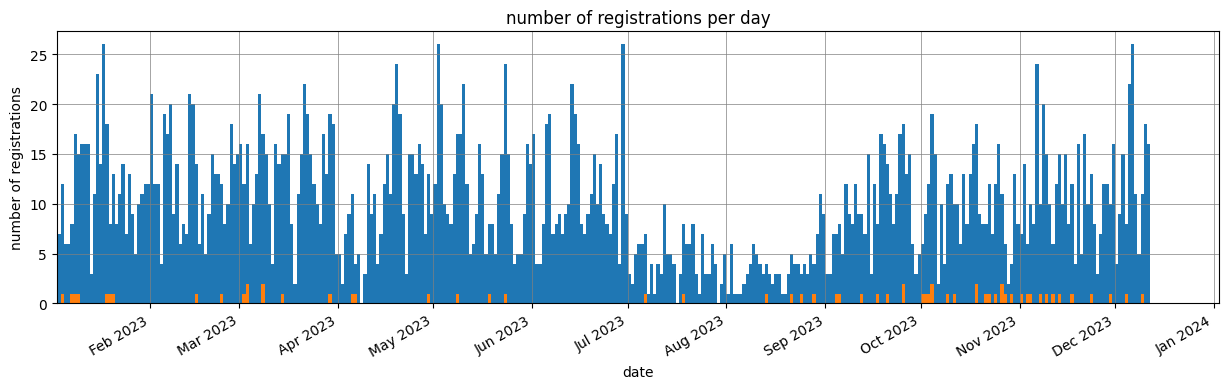

In [29]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("""Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!
""")

def plot_dataframe(df):
    df.reset_index()
    days = df.reset_index()['registration_day'].tolist()
    registrations = df['num_registrations'].tolist()
    plt.bar(days, registrations, width=1, align='edge')

plt.figure(figsize=(15, 4))
plot_dataframe(user_registrations)
plot_dataframe(users_registered_that_logged_in_again_on_a_different_day)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('date')
today = datetime.today()
plt.xlim([today-timedelta(365), today])
plt.ylabel('number of registrations')
plt.title('number of registrations per day')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

In [4]:
import mysql.connector

mysql_connection = mysql.connector.connect(
    database="serlo",
    host="localhost",
    user="root",
    password="secret",
    port="3306"
)

       user_id  edit_date
0       263711 2023-01-02
1       169563 2023-01-02
2       169563 2023-01-02
3       169563 2023-01-02
4       262283 2023-01-02
...        ...        ...
18532   148701 2023-12-11
18533   148701 2023-12-11
18534   148701 2023-12-11
18535   148701 2023-12-11
18536   148701 2023-12-11

[18537 rows x 2 columns]
user_id               int64
edit_date    datetime64[ns]
dtype: object
       user_id registration_date
0       148701        2022-12-12
1       114065        2022-12-12
2       131531        2022-12-12
3       142380        2022-12-12
4        27693        2022-12-12
...        ...               ...
22716   262283        2022-12-12
22717   240298        2022-12-12
22718   258048        2022-12-12
22719   203486        2022-12-12
22720   204201        2022-12-12

[22673 rows x 2 columns]
user_id                       int64
registration_date    datetime64[ns]
dtype: object
int64


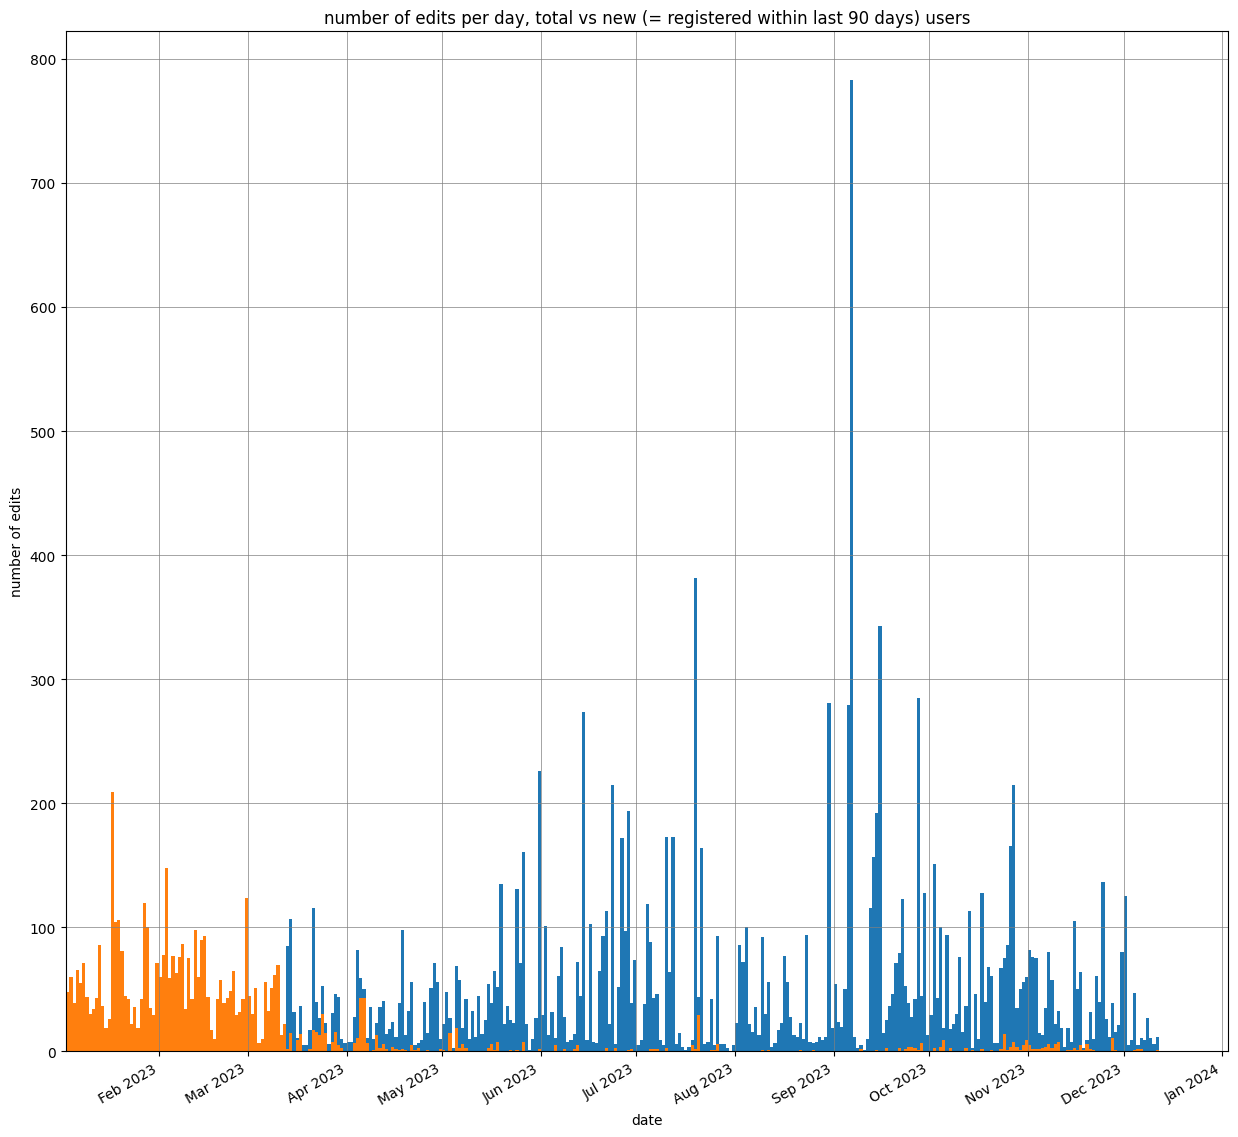

In [60]:
# get total edits per day
query = """
SELECT DATE(date) AS edit_day, COUNT(*) 
FROM event_log
JOIN event ON event_log.event_id = event.id
WHERE DATE(date) >= DATE(CURRENT_DATE - INTERVAL 1 year)
AND event.name = 'entity/revision/add' -- assuming that an added revision is the same as an edit
GROUP BY edit_day
ORDER BY edit_day
"""
cursor = mysql_connection.cursor()
cursor.execute(query)
editor_and_date = cursor.fetchall()
df = pd.DataFrame(editor_and_date, columns=['edit_day', 'num_edits'])
df['edit_day'] = pd.to_datetime(df['edit_day'])
if df.index[-1] != pd.to_datetime('today').normalize():
    df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
edits_per_day = df.set_index('edit_day').resample('D').sum().fillna(value=0)

def plot_dataframe(df):
    df.reset_index()
    days = df.reset_index()['edit_day'].tolist()
    edits = df['num_edits'].tolist()
    plt.bar(days, edits, width=1, align='edge')
    return (days, edits)

# get user and date for all edits (entity/revision/add)
query = """
SELECT actor_id, DATE(date) AS edit_date
FROM event_log
JOIN event ON event_log.event_id = event.id
WHERE DATE(date) >= DATE(CURRENT_DATE - INTERVAL 1 year)
AND event.name = 'entity/revision/add' -- assuming that an added revision is the same as an edit
"""
cursor = mysql_connection.cursor()
cursor.execute(query)
editor_and_date = cursor.fetchall()

query = """
SELECT (metadata_public->>'legacy_id'), DATE_TRUNC('day', created_at) AS registration_day
FROM identities
WHERE DATE_TRUNC('day', created_at) >= DATE_TRUNC('day', CURRENT_DATE - INTERVAL '460 days')
"""
cursor = postgres_connection.cursor()
cursor.execute(query)
user_and_registration_date = cursor.fetchall()

# Convert the lists to pandas dataframes
edits_df = pd.DataFrame(editor_and_date, columns=['user_id', 'edit_date'])
edits_df['edit_date'] = pd.to_datetime(edits_df['edit_date'])
registrations_df = pd.DataFrame(user_and_registration_date, columns=['user_id', 'registration_date'])
registrations_df = registrations_df.dropna(subset=['user_id'])
registrations_df['user_id'] = registrations_df['user_id'].astype('int64')
print(edits_df)
print(edits_df.dtypes)
print(registrations_df)
print(registrations_df.dtypes)

merged_df = pd.merge(edits_df, registrations_df, on='user_id')
filtered_df = merged_df[(merged_df['edit_date'] - merged_df['registration_date']) <= timedelta(days=90)]
df = filtered_df['edit_date'].value_counts().sort_index()
print(df.dtypes)

days = df.index
edits_by_new_users_per_day = df.values



plt.figure(figsize=(15, 15))
plot_dataframe(edits_per_day)
plt.bar(days, edits_by_new_users_per_day, width=1, align='edge')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('date')
today = datetime.today()
plt.xlim([today-timedelta(365), today])
plt.ylabel('number of edits')
plt.title('number of edits per day, total vs new (= registered within last 90 days) users')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()